In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

## Step 1. Read file

In [2]:
# The file doesn't have header, so I have to define the column names
columns = ['user_id', 'order_dt', 'order_products', 'order_amount']
# Use read_table() to read text file. File delimiter is space.
df = pd.read_table('CDNOW_master.txt', names=columns, sep='\s+')

In [3]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


Note: the user can order multiple times in one day. E.g. user 2 have 2 orders on 19970112

In [4]:
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


Each order has 2.41 products by average. Std is 2.33. It shows a little volatility. The medium (50%) is 2 and 75% is 3 which means most orders have a few products each. From order_amount, we can see most orders are cheap.  

Note: The consumption data is usually long-tailed. Most customers spend a few money and a few customers spend a large amount. This is also called 2/8 (Pareto principle).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


No null value. Very clean data.

## Step 2. Add column "month"

In [6]:
df['order_date'] = pd.to_datetime(df.order_dt, format = '%Y%m%d')

In [7]:
df['month'] = df.order_date.values.astype('datetime64[M]') # change to month. Note: it will display as the 1st day of the month

In [8]:
df.head()

,user_id,order_dt,order_products,order_amount,order_date,month
0,1,19970101,1,11.77,1997-01-01,1997-01-01
1,2,19970112,1,12.00,1997-01-12,1997-01-01
2,2,19970112,5,77.00,1997-01-12,1997-01-01
3,3,19970102,2,20.76,1997-01-02,1997-01-01
4,3,19970330,2,20.76,1997-03-30,1997-03-01


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 6 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
order_date        69659 non-null datetime64[ns]
month             69659 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 3.2 MB


## Step 3. Data exploration

In [61]:
user_grouped = df.groupby('user_id').sum()
user_grouped.head()

,order_dt,order_products,order_amount
user_id,,,
1,19970101,1,11.77
2,39940224,6,89.00
3,119833602,16,156.46
4,79882233,7,100.50
5,219686137,29,385.61


In [62]:
user_grouped.describe()

,order_dt,order_products,order_amount
count,2.357000e+04,23570.000000,23570.000000
mean,5.902627e+07,7.122656,106.080426
std,9.460684e+07,16.983531,240.925195
min,1.997010e+07,1.000000,0.000000
25%,1.997021e+07,1.000000,19.970000
50%,1.997032e+07,3.000000,43.395000
75%,5.992125e+07,7.000000,106.475000
max,4.334408e+09,1033.000000,13990.930000


The average number of products in each order is 7.1 and is close to 75% which means some customers had ordered lots of products.

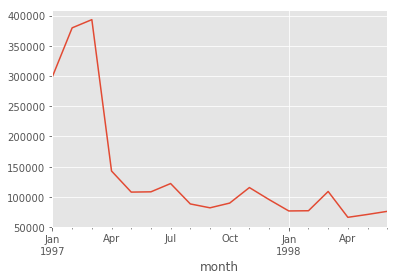

In [63]:
# Plot the total order amount by month
df.groupby('month').order_amount.sum().plot()

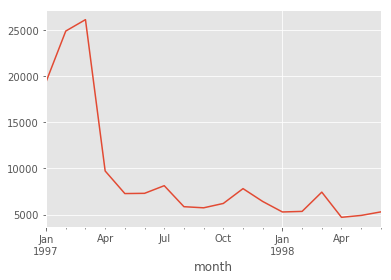

In [64]:
df.groupby('month').order_products.sum().plot()

Both order_amount and order_products show the sales had reached a peak in the first several months. This is suspicious. It could be due to outlier or promotion activity. But we only have sales data, it's hard to determine.

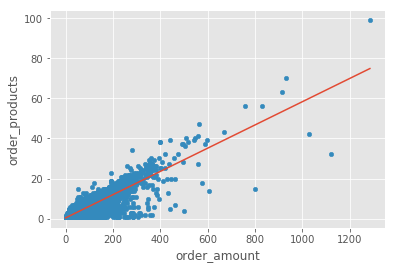

In [65]:
# Draw scatter plot for each order
ax = df.plot.scatter(x = 'order_amount',  y = 'order_products')

# Add a fitting line
x = df['order_amount']
y = df['order_products']
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

We can see the relationship between order_products and order_amount. The price of each product is around 10. Only a few order_amount are over 1000. It is probably not due to outlier.

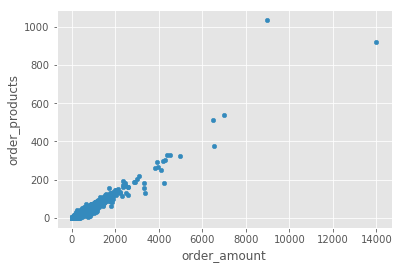

In [66]:
# Draw scatter plot for each customer
df.groupby('user_id').sum().plot.scatter(x = 'order_amount',  y = 'order_products')

The amount and products are almost linear.

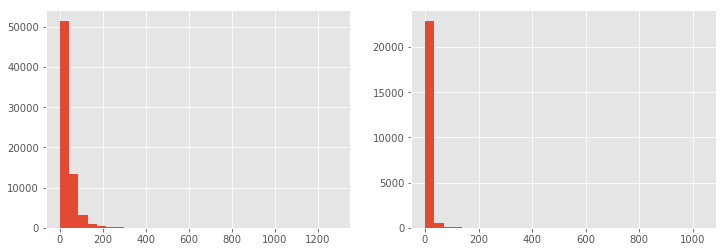

In [67]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
df.order_amount.hist(bins = 30)


plt.subplot(122)
df.groupby('user_id').order_products.sum().hist(bins = 30)

In [68]:
df.groupby('user_id').month.min().value_counts()

1997-02-01    8476
1997-01-01    7846
1997-03-01    7248
Name: month, dtype: int64

We count the min month by grouping user which means the first time when the customer purchased.  
We can see the first purchase of all the customers happened within the first 3 months.   
This implies that the data records the consumption in the past 18 months for the customers who had purchase within several specific months.

In [69]:
df.groupby('user_id').month.max().value_counts()

1997-02-01    4912
1997-03-01    4478
1997-01-01    4192
1998-06-01    1506
1998-05-01    1042
1998-03-01     993
1998-04-01     769
1997-04-01     677
1997-12-01     620
1997-11-01     609
1998-02-01     550
1998-01-01     514
1997-06-01     499
1997-07-01     493
1997-05-01     480
1997-10-01     455
1997-09-01     397
1997-08-01     384
Name: month, dtype: int64

We check the max month and result also shows the most of purchases happened in the first several months.  
Here we regard all the customers as new customers.

## Step 4. Create pivot table for further check

In [70]:
# Create pivot table to calculate number of orders by user by month
pivot_counts = df.pivot_table(index = 'user_id', columns = 'month', values = 'order_dt', aggfunc = 'count').fillna(0)
# Without astype('str'), the "month" column will display as "1997-01-01 00:00:00"
columns_month = df.month.sort_values().astype('str').unique() 
pivot_counts.columns = columns_month

pivot_counts.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


### Step 4.1 Calculate repeat purchase rate (复购率)

In [71]:
# Analyze multiple purchase rate
# Purchase > 1  record as 1, purchase == 1 record as 0, purchase == 0 record as NaN
pivot_counts_transf = pivot_counts.applymap(lambda x: 1 if x > 1 else np.NaN if x == 0 else 0)
pivot_counts_transf.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


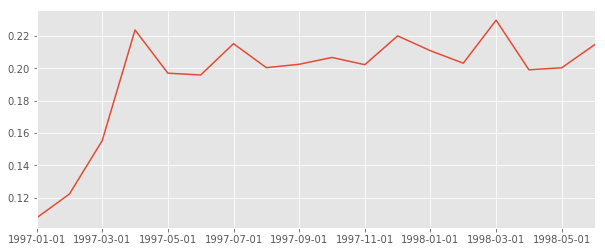

In [72]:
(pivot_counts_transf.sum() / pivot_counts_transf.count()).plot(figsize = (10, 4))

We can see the multiple purchase rate of new customer is very low (around 6%) at the beginning. Later, the rate increases and keep at around 20%.

### Step 4.2 Calculate repurchase rate

In [73]:
# Analyze repurchase rate
pivoted_amount = df.pivot_table(index = 'user_id',  columns = 'month',
                               values = 'order_amount', aggfunc = 'mean').fillna(0)
columns_month = df.month.sort_values().astype('str').unique()
pivoted_amount.columns = columns_month

In [74]:
pivoted_amount.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,11.77,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
2,44.50,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
3,20.76,0.0,20.76,19.54,0.00,0.00,0.00,0.00,0.00,0.0,39.205,0.000,0.00,0.0,0.0,0.0,16.99,0.0
4,29.53,0.0,0.00,0.00,0.00,0.00,0.00,14.96,0.00,0.0,0.000,26.480,0.00,0.0,0.0,0.0,0.00,0.0
5,21.65,38.9,0.00,45.55,38.71,26.14,28.14,0.00,40.47,0.0,0.000,43.465,37.47,0.0,0.0,0.0,0.00,0.0


In [75]:
pivoted_purchase = pivoted_amount.applymap(lambda x: 1 if x > 0 else 0)
pivoted_purchase.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [76]:
def purchase_return(data):
    status = []
    for i in range(17):  # the input file has 18 months data
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    return status

pivoted_purchase_return = pivoted_purchase.apply(purchase_return, axis = 1)
pivoted_purchase_return.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


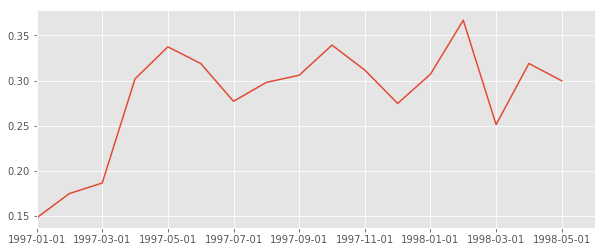

In [77]:
(pivoted_purchase_return.sum() / pivoted_purchase_return.count()).plot(figsize = (10, 4))

The repurchase rate is higher than multiple purchase rate. The new customers have lower repurchase rate (15%).  
In general, mature customers are better than new customers. They have higher repurchase rate, but the shopping frequency is a little low.  
This is the customer feature of CDNow.

### Step 4.3 Customer segmentation

In [78]:
# Define unreg/new/active/unactive/return customer
# E.g.
# new - customer has first purchase on Jan
# active - customr has purchase on Feb (already has purchase on Jan)
# unactive - customer doesn't purchase anything on March
# return - customer has purchase on Apr
# unreg - if customer has first purchase on March, then (s)he is a unregistered customer on Jan and Feb
def active_status(data):
    status = []
    for i in range(18):
        # if no purchase in current month
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg': # unregistered customer
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        # if has purchase in current month
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return status

pivoted_purchase_status = pivoted_purchase.apply(active_status, axis = 1)
pivoted_purchase_status.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [79]:
purchase_status_counts = pivoted_purchase_status.replace('unreg', np.NaN).apply(lambda x: pd.value_counts(x))
purchase_status_counts.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1155.0,1680,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624,632.0,512.0,472.0,569.0,517.0,458.0,446.0
new,7814.0,8455.0,7231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1402,1232.0,1025.0,1079.0,1489.0,919.0,1030.0,1060.0
unactive,NaN,6659.0,13994,20678.0,21286.0,21161.0,21320.0,21728.0,21761.0,21661.0,21474,21638.0,21965.0,21951.0,21444.0,22066.0,22014.0,21996.0


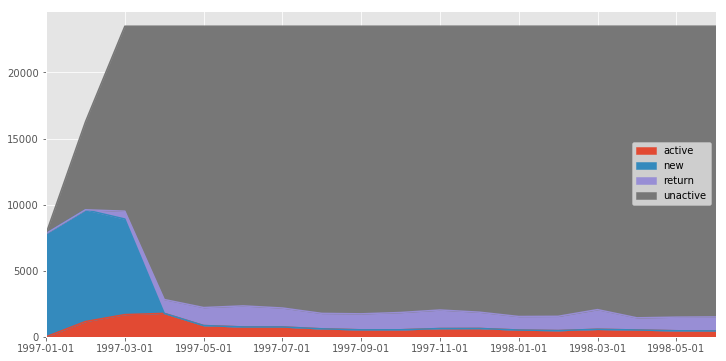

In [110]:
purchase_status_counts.fillna(0).T.plot.area(figsize = (12, 6))

Just need to check red and purple area. The sum of them are the percentage of the consumers (no new customer later).

### Step 4.4 Calculate return rate (回流率)

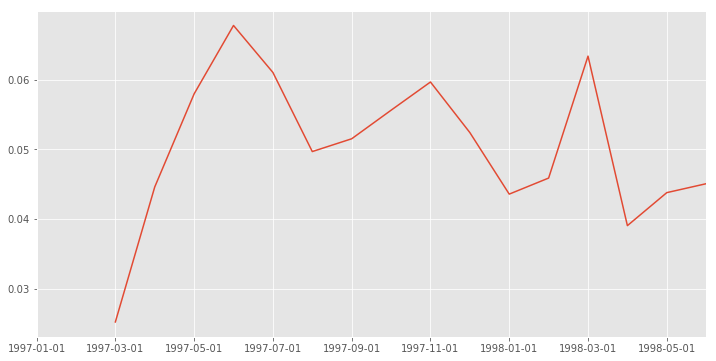

In [81]:
return_rate = purchase_status_counts.apply(lambda x: x/x.sum(), axis = 0)
return_rate.loc['return'].plot(figsize = (12,6))

The rate of return customers is about 4% to 7% and has a decreasing trend.

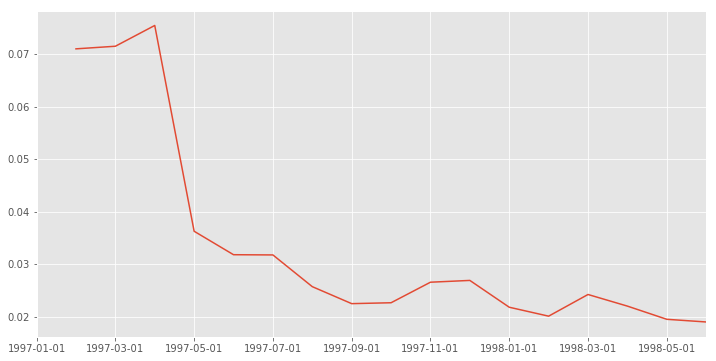

In [82]:
return_rate.loc['active'].plot(figsize = (12,6))

Active customers are continue decreasing and the rate of active customers is about 2% to 3%.  
In general, we have 70% return customers and 30% active customers in later purchase.

### Step 4.5 Analyze customer quality

In [83]:
# cumsum() add the order amount line by line. The last one is the total amount (2500315)
user_amount = df.groupby('user_id').order_amount.sum().sort_values().reset_index()
user_amount['amount_cumsum'] = user_amount.order_amount.cumsum()
user_amount.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


In [84]:
amount_total = user_amount.amount_cumsum.max()
user_amount['prop'] = user_amount.apply(lambda x: x.amount_cumsum/amount_total, axis = 1)
user_amount.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


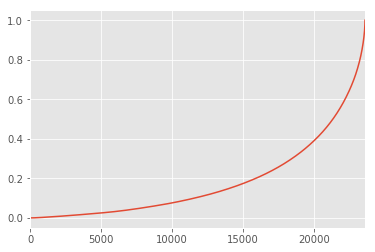

In [85]:
user_amount.prop.plot()

The x tick is ordered by contributed amount (small to large) and y tick is the cumulative amount percentage.  
We can see the first 20000 customers contribute 40% order amount while the last 4000 customers contribute 60%.   
This is consistent with Pareto principle.

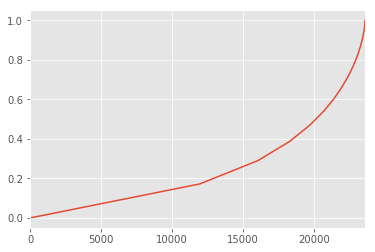

In [86]:
# Do the same to calculate order products
user_counts = df.groupby('user_id').order_dt.count().sort_values().reset_index()
user_counts['counts_cumsum'] = user_counts.order_dt.cumsum()
counts_total = user_counts.counts_cumsum.max()
user_counts['prop'] = user_counts.apply(lambda x: x.counts_cumsum/counts_total, axis = 1)
user_counts.prop.plot()

The first 20000 customers consume 45% products while last 4000 high end customers consume 55% products.  
In consumer industry, we should be always stick with high end customers.

### Step 4.6 Customer lifetime

In [87]:
# consumer life cycle - first purchase to last purchase
user_purchase = df[['user_id', 'order_products','order_amount', 'order_date']]
order_date_min = user_purchase.groupby('user_id').order_date.min()
order_date_max = user_purchase.groupby('user_id').order_date.max()

In [88]:
(order_date_max - order_date_min).head(10)

user_id
1      0 days
2      0 days
3    511 days
4    345 days
5    367 days
6      0 days
7    445 days
8    452 days
9    523 days
10     0 days
Name: order_date, dtype: timedelta64[ns]

In [89]:
(order_date_max - order_date_min).mean()

Timedelta('134 days 20:55:36.987696')

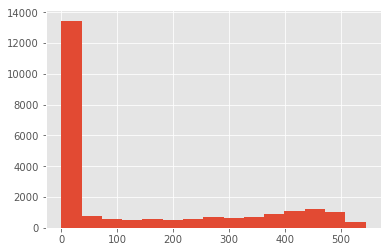

In [90]:
((order_date_max - order_date_min)/np.timedelta64(1, 'D')).hist(bins = 15)

Most customers have only 1 purchase.

In [91]:
life_time = (order_date_max - order_date_min).reset_index()
life_time.head()

,user_id,order_date
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days


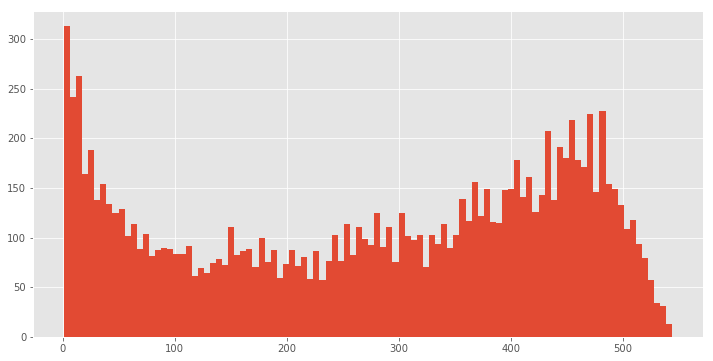

In [92]:
life_time['life_time'] = life_time.order_date/np.timedelta64(1, 'D')
life_time[life_time.life_time > 0].life_time.hist(bins = 100, figsize = (12, 6))

life cycle = 50 - 300 days: regular customers   
life cycle = 400+ days: high quality customers

In [93]:
# The percentage of high quality customers of total return customers
(life_time[life_time.life_time > 400].user_id.count())/ (life_time[life_time.life_time > 0].user_id.count())

0.31703716568252865

In [94]:
# The percentage of high quality customers of total customers
(life_time[life_time.life_time > 400].user_id.count())/ (life_time.user_id.count())

0.15490029698769622

In [95]:
life_time[life_time.life_time > 0].life_time.mean()

276.0448072247308

### Step 4.7 Customer retention rate

In [96]:
# retention rate
user_purchase_retention = pd.merge(left = user_purchase, right = order_date_min.reset_index(),
                                  how = 'inner', on = 'user_id',
                                  suffixes = ('', '_min'))
user_purchase_retention.head(5)

,user_id,order_products,order_amount,order_date,order_date_min
0,1,1,11.77,1997-01-01,1997-01-01
1,2,1,12.00,1997-01-12,1997-01-12
2,2,5,77.00,1997-01-12,1997-01-12
3,3,2,20.76,1997-01-02,1997-01-02
4,3,2,20.76,1997-03-30,1997-01-02


In [97]:
user_purchase_retention['order_date_diff'] = user_purchase_retention.order_date - user_purchase_retention.order_date_min
user_purchase_retention.head()

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff
0,1,1,11.77,1997-01-01,1997-01-01,0 days
1,2,1,12.00,1997-01-12,1997-01-12,0 days
2,2,5,77.00,1997-01-12,1997-01-12,0 days
3,3,2,20.76,1997-01-02,1997-01-02,0 days
4,3,2,20.76,1997-03-30,1997-01-02,87 days


In [98]:
# date transfers to time
date_trans = lambda x: x/np.timedelta64(1, 'D')

user_purchase_retention['date_diff'] = user_purchase_retention.order_date_diff.apply(date_trans)
user_purchase_retention.head(10)

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0
5,3,2,19.54,1997-04-02,1997-01-02,90 days,90.0
6,3,5,57.45,1997-11-15,1997-01-02,317 days,317.0
7,3,4,20.96,1997-11-25,1997-01-02,327 days,327.0
8,3,1,16.99,1998-05-28,1997-01-02,511 days,511.0
9,4,2,29.33,1997-01-01,1997-01-01,0 days,0.0


In [99]:
bin = [0,3,7,15,30,60,90,180,365]
user_purchase_retention['date_diff_bin'] = pd.cut(user_purchase_retention.date_diff, bins=bin)

In [100]:
# bucket the date diff by time difference
user_purchase_retention.head(20)

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff,date_diff_bin
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0,NaN
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0,NaN
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0,NaN
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0,NaN
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0,"(60, 90]"
5,3,2,19.54,1997-04-02,1997-01-02,90 days,90.0,"(60, 90]"
6,3,5,57.45,1997-11-15,1997-01-02,317 days,317.0,"(180, 365]"
7,3,4,20.96,1997-11-25,1997-01-02,327 days,327.0,"(180, 365]"
8,3,1,16.99,1998-05-28,1997-01-02,511 days,511.0,NaN
9,4,2,29.33,1997-01-01,1997-01-01,0 days,0.0,NaN


In [101]:
pivoted_retention = user_purchase_retention.pivot_table(index = 'user_id', columns = 'date_diff_bin', 
                                                       values = 'order_amount', aggfunc = sum)
pivoted_retention.head(10)

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,40.3,NaN,78.41
4,NaN,NaN,NaN,29.73,NaN,NaN,NaN,41.44
5,NaN,NaN,13.97,NaN,38.90,NaN,110.40,155.54
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.43
8,NaN,NaN,NaN,NaN,13.97,NaN,45.29,104.17
9,NaN,NaN,NaN,NaN,NaN,NaN,30.33,NaN


The above shows how much does each customer spent after first purchase.

In [102]:
# The average purchase amount after first purchase.
pivoted_retention.mean()

date_diff_bin
(0, 3]        35.905798
(3, 7]        36.385121
(7, 15]       42.669895
(15, 30]      45.964649
(30, 60]      50.215070
(60, 90]      48.975277
(90, 180]     67.223297
(180, 365]    91.960059
dtype: float64

In [103]:
# 1: customer has purchase aftert 1st purchase, 0: customer has no purchase after 1st purchase
pivoted_retention_trans = pivoted_retention.fillna(0).applymap(lambda x: 1 if x > 0 else 0)
pivoted_retention_trans.head()

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,1
5,0,0,1,0,1,0,1,1


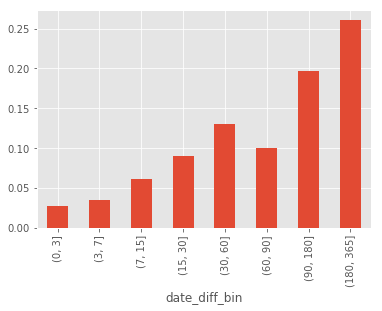

In [104]:
(pivoted_retention_trans.sum()/pivoted_retention_trans.count()).plot.bar()

Only 2.5% customers has next purchase within (0,3] days after 1st purchase.  
20% customers has next purchase within (90, 180] days after 1st purchase.  
27% customers has next purchase after half or one year after 1st purchase.

### Step 4.8 Calculate customer average purchase interval

In [105]:
# averge purchase cycle
# only for illustration, not recommended
grouped = user_purchase_retention.groupby('user_id')
i = 0
for user, group in grouped:
    print(group)
    i += 1
    if i == 2:
        break

   user_id  order_products  order_amount order_date order_date_min  \
0        1               1         11.77 1997-01-01     1997-01-01   

  order_date_diff  date_diff date_diff_bin  
0          0 days        0.0           NaN  
   user_id  order_products  order_amount order_date order_date_min  \
1        2               1          12.0 1997-01-12     1997-01-12   
2        2               5          77.0 1997-01-12     1997-01-12   

  order_date_diff  date_diff date_diff_bin  
1          0 days        0.0           NaN  
2          0 days        0.0           NaN  


In [106]:
def diff(group):
    d = group.date_diff - group.date_diff.shift(-1)
    return d

last_diff = user_purchase_retention.groupby('user_id').apply(diff)
last_diff.head()

user_id   
1        0     NaN
2        1     0.0
         2     NaN
3        3   -87.0
         4    -3.0
Name: date_diff, dtype: float64

In [107]:
last_diff.mean()

-68.97376814424265

The average purchase cycle of each customer is 68 days.  
If we want to get back customers, we should do that at around 60 day.

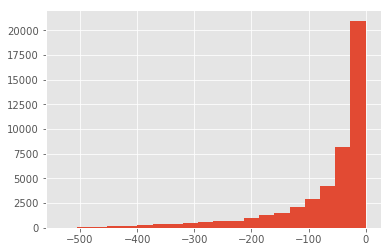

In [108]:
last_diff.hist(bins = 20)

Classical long-tail plot.  
Most customers have short purchase intervals.  
The strategy could be:  
1. Grant coupon after purchase
2. Ask what about the CD 10 days after purchase
3. Remind the coupon will expire 30 days after purchase
4. Send text message 60 days after purchase